In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas

In [2]:
from scipy.integrate import ode
df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs/ yobs.std(axis=0)
N = len(times)




In [3]:
lk_data = {
    'N' : N,
    'ts' : times.tolist(),
    'y_init' : yobs_norm[0].tolist(),
    'y' : yobs_norm.tolist(),
    'slab_df' : 4.0,
    'slab_scale' : 2.0,
    'd' : 6,
}

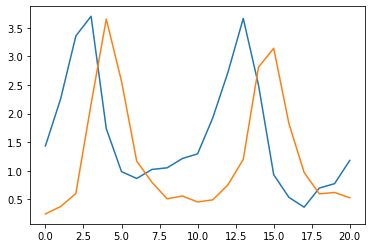

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(yobs_norm)
plt.show()

In [5]:
inp = yobs_norm
u = inp[:,0]
v = inp[:,1]

θ = np.array([u,v,u*v]).T

import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
dx = sfd(inp)
guess = np.linalg.lstsq(θ,dx)[0]

/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


In [6]:
guess

array([[ 0.38442723,  0.06679346],
       [-0.14255721, -0.60448961],
       [-0.23353696,  0.32225384]])

In [7]:
def my_init():
    return {"sigma" : [0.1, 0.1],
            "theta" : guess.flatten().tolist(),
            "tau" : 0.1,
            "lambda" : np.ones(6).tolist(), #[8.4, 0.88, 1.6, 12.8, 10.0, 19.0],
            "z_init" : yobs_norm[0].tolist(),
            "c" : 2.5,
            "my_z" : (guess.flatten() / 0.1).tolist(),  #[1.17, 0.083, 0.16, -1.1, -1.0, 1.0 ]
    }

In [19]:
lotka_stan = """
functions {
  real[] dz_dt(real t,       // time
               real[] z,     // system state {prey, predator}
               real[] theta, // parameters
               real[] x_r,   // unused data
               int[] x_i) {
    real u = z[1];
    real v = z[2];

    real du_dt = theta[1] * u + theta[3] * v + theta[5] * u * v  - 1e-3 * u * u * u;
    real dv_dt = theta[2] * u + theta[4] * v + theta[6] * u * v - 1e-3 * v * v * v;

    return { du_dt, dv_dt };
  }
}
data {
  int<lower = 0> N;          // number of measurement times
  real ts[N];                // measurement times > 0
  real y_init[2];            // initial measured populations
  real<lower = 0> y[N, 2];   // measured populations
  real slab_df;
  real slab_scale;
  int<lower = 0> d;
}
parameters {
  vector <lower = 0>[d] lambda;
  real<lower = 0> z_init[2];  // initial population
  vector <lower = 0>[2] sigma;   // measurement errors
  real<lower=0> tau;
  vector[d] my_z;
  real <lower=0> caux;
  
}
transformed parameters {
  vector<lower=0>[d] lambda_tilde;
  real<lower=0> c;
  real theta[d];
  real z[N,2];
  c = slab_scale * sqrt(caux);
  lambda_tilde = sqrt( c^2 * square(lambda) ./ (c^2 + tau^2*square(lambda)) ); 
  for (k in 1:d){
     theta[k] = my_z[k] * lambda_tilde[k] * tau;}
  z = integrate_ode_bdf(dz_dt, z_init, 0, ts, theta,
                         rep_array(0.0, 0), rep_array(0, 0),
                         1e-5, 1e-3, 2e3);
}
model {
  lambda ~ student_t(1.0, 0.0, 1.0);
  tau ~ student_t(1.0, 0.0, 0.1);
  caux ~ inv_gamma(0.5 * slab_df, 0.5 * slab_df * square(slab_scale));
  my_z ~ normal(0.0, 1.0);
  sigma ~ lognormal(-1, 0.1);
  z_init ~ lognormal(log(1), 1);
  for (k in 1:2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ , k] ~ lognormal(log(z[, k]), sigma[k]);
  }
}
generated quantities {
  real y_init_rep[2];
  real y_rep[N, 2];
  for (k in 1:2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1:N)
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
  }
}"""

In [20]:
import pystan
sm = pystan.StanModel(model_code=lotka_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0be12d4edcd65648663f666752fb6dd2 NOW.


ImportError: /tmp/pystan_qpb_9bjz/stanfit4anon_model_0be12d4edcd65648663f666752fb6dd2_9095848004869105431.cpython-37m-x86_64-linux-gnu.so: undefined symbol: CVodeGetSens

In [18]:
fit = sm.sampling(data=lk_data, chains=2, algorithm='NUTS', seed=2, init=my_init)

RuntimeError: Exception: Max number of iterations exceeded (2000).  (in 'unknown file name' at line 44)


In [ ]:
fit

In [ ]:
az.plot_trace(fit, var_names=['theta'])

In [ ]:
import arviz as az
plt.figure()
myplot = az.plot_forest(fit, var_names=['theta'], kind='ridgeplot', combined=True, figsize=(6,12), ridgeplot_quantiles=[.25, .5, .75])[0]
plt.title('Posterior')
plt.tight_layout()
plt.show()